In [93]:
import numpy
import math
import torch
import pandas
import timeit
from timeit import default_timer as timer

In [94]:
%matplotlib inline

In [95]:
torch.cuda.is_available()

True

In [96]:
cuda0 = torch.device('cuda:0')

In [97]:
def assetPathsCPU(S0,mu,sigma,T,nRows,nPaths):
    dt = T/nRows
    nudt = (mu-0.5*sigma**2)*dt    
    sidt = sigma*math.sqrt(dt)
    increments = nudt + sidt*numpy.random.randn(int(nRows),int(nPaths))
    x=numpy.concatenate((math.log(S0)*numpy.ones((1,int(nPaths))),increments))
    pricePaths=numpy.exp(numpy.cumsum(x,axis=0))

    return pricePaths

def assetPathsGPU(S0,mu,sigma,T,nRows,nPaths,dtype,device):
    dt = T/nRows
    nudt = (mu-0.5*sigma**2)*dt
    sidt = sigma*torch.sqrt(dt)
    pricePaths=torch.exp(torch.cumsum(torch.cat((torch.log(S0)*torch.ones(1,nPaths,dtype=dtype,device=cuda0),
        torch.distributions.Normal(nudt,sidt).sample((nRows, nPaths)).squeeze()), dim=0),dim=0))
    
    return pricePaths

In [98]:
%%timeit

nRows=2500
nPaths=10000
dtype=torch.double
# define parameters
S0 = torch.tensor([100.0],requires_grad=False,dtype=dtype, device=cuda0)
T = torch.tensor([10.0],requires_grad=False,dtype=dtype, device=cuda0)
mu = torch.tensor([0.08],requires_grad=False,dtype=dtype, device=cuda0)
sigma = torch.tensor([0.1],requires_grad=False,dtype=dtype, device=cuda0)
# simulate price paths on the CPU
assetPathsGPU(S0,mu,sigma,T,nRows,nPaths,dtype,cuda0)

15.2 ms ± 205 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [99]:
randomSeed=12345678
# set random seed
torch.manual_seed(randomSeed)

nRows=2500
nPaths=10000
dtype=torch.double
# define parameters
S0 = torch.tensor([100.0],requires_grad=False,dtype=dtype, device=cuda0)
T = torch.tensor([10.0],requires_grad=False,dtype=dtype, device=cuda0)
mu = torch.tensor([0.08],requires_grad=False,dtype=dtype, device=cuda0)
sigma = torch.tensor([0.1],requires_grad=False,dtype=dtype, device=cuda0)
# simulate price paths on the CPU
assetPathsGPU(S0,mu,sigma,T,nRows,nPaths,dtype,cuda0)
# simulate price paths on the GPU
pricePathsGPU=assetPathsGPU(S0,mu,sigma,T,nRows,nPaths,dtype,cuda0)

In [100]:
%%timeit

nRows=2500
nPaths=10000
# define parameters
S0 = 100.0
T = 10.0
mu = 0.08
sigma = 0.1
# simulate price paths
assetPathsCPU(S0,mu,sigma,T,nRows,nPaths)


1.27 s ± 6.15 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


The GPU version is significantly faster than the CPU version as expected

In [101]:
numpy.random.seed(randomSeed)

nRows=2500
nPaths=10000
# define parameters
S0 = 100.0
T = 10.0
mu = 0.08
sigma = 0.1
# simulate price paths
pricePathsCPU=assetPathsCPU(S0,mu,sigma,T,nRows,nPaths)

In [102]:
pricePathsGPU_CPU=pricePathsGPU.cpu().numpy()
pricePathsCpuDf=pandas.DataFrame(pricePathsCPU)
pricePathsGpuDf=pandas.DataFrame(pricePathsGPU_CPU)
meanGPU=pricePathsGpuDf.mean(axis=1)
meanCPU=pricePathsCpuDf.mean(axis=1)

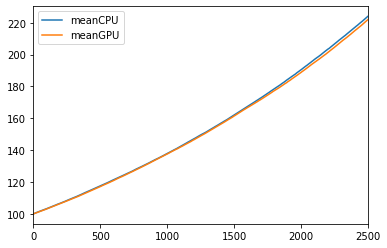

In [103]:
meanCompare=pandas.concat({'meanCPU' : meanCPU,'meanGPU' : meanGPU},axis=1)
meanCompare.plot()

Now we define the functions where I expect a speed up, but do not see one:

In [104]:
def emaNPathsCPU(pricePaths,lookback):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    ema=numpy.zeros([int(T),int(nPaths)])
    # compute the smoothing constant
    a = 2.0 / ( lookback + 1.0 )
    # iterate over each price path
    for pathIndex in range(0,int(nPaths)):
        # iterate over each price path
        ema[0,pathIndex] = pricePaths[0,pathIndex]
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            ema[t,pathIndex]=a * (pricePaths[t,pathIndex]-ema[t-1,
                pathIndex]) + ema[t-1,pathIndex]
    return ema

def emaNPathsGPU(pricePaths,lookback,dtype,device):
    # find T and nPaths
    T,nPaths=pricePaths.shape
    # create output array
    #ema=numpy.zeros([int(T),int(nPaths)])
    ema=torch.zeros(T,nPaths,dtype=dtype,device=device)  
    # compute the smoothing constant
    a = 2.0 / ( lookback + 1.0 )
    ema[0,:] = pricePaths[0,:]    
    # iterate over each price path
    for pathIndex in range(nPaths):
        # iterate over each point in time and compute the EMA 
        for t in range(1,T):
            ema[t,pathIndex]=a * (pricePaths[t,pathIndex]-ema[t-1,
                pathIndex]) + ema[t-1,pathIndex]
    return ema


We pass our fake price paths to the GPU version:

In [105]:
pricePathsGPU[:,0:1000].shape

torch.Size([2501, 1000])

In [106]:
lookbackGPU=torch.tensor(90.0,dtype=dtype,device=cuda0)
dtype=torch.float64
# start timer (EMA)
ts_emaGPU = timer()
# EMA on paths
emaGPU=emaNPathsGPU(pricePathsGPU[:,0:1000],lookbackGPU,dtype,cuda0)
# end timer (prices)
te_emaGPU = timer()
# compute time elasped
timeElasped_emaGPU=te_emaGPU-ts_emaGPU
# display time elasped
print('EMA Time Elasped (GPU): '+str(timeElasped_emaGPU))

EMA Time Elasped (GPU): 107.70547575701494


We pass our fake price paths to the CPU version:

In [109]:
pricePathsGPU_CPU=pricePathsGPU.cpu().numpy()
lookbackCPU=90.0
# start timer (EMA)
ts_emaCPU = timer()
# EMA on paths
emaCPU=emaNPathsCPU(pricePathsGPU_CPU[:,0:1000],lookbackCPU)
# end timer (EMA)
te_emaCPU = timer()
# compute time elasped
timeElasped_emaCPU=te_emaCPU-ts_emaCPU
# display time elasped
print('EMA Time Elasped (CPU): '+str(timeElasped_emaCPU))

EMA Time Elasped (CPU): 3.875478568021208


Why is the GPU version so slow?

What can I do to make the PyTorch version faster?